# Comparison of synthetic and real data

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as spstats

In [36]:
from dap import DAPcython
from dap.utils import obs_params_gbar, syn_current
from dap.cell_fitting.read_heka import (get_sweep_index_for_amp, get_i_inj_from_function,
                                        get_v_and_t_from_heka, shift_v_rest)
from dap.dap_sumstats import DAPSummaryStats
from dap.dap_sumstats_moments import DAPSummaryStatsMoments

np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

## load real data

In [2]:
data_dir = '/home/ateska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'  # best cell
protocol = 'IV'
ramp_amp = 1

In [4]:
v_shift = -16  # shift for accounting for the liquid junction potential

if protocol == 'Zap20':
    sweep_idx = 0
else:
    sweep_idx = get_sweep_index_for_amp(ramp_amp, protocol)

V, t = get_v_and_t_from_heka(data_dir, protocol, sweep_idxs=[sweep_idx])
V = shift_v_rest(V[0], v_shift)
t = t[0]
dt = t[1] - t[0]

I, t_on, t_off = get_i_inj_from_function(protocol, [sweep_idx], t[-1], dt,
                                         return_discontinuities=False)
I = I[0]

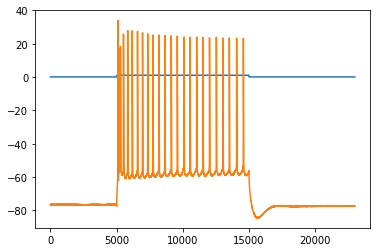

In [6]:
plt.plot(I)
plt.plot(V);

## generate syntetic data

In [7]:
params, labels = obs_params_gbar(reduced_model=False)
params = params*10
# I, t, t_on, t_off = syn_current(duration=120, dt=dt)

In [8]:
labels

['gbar_nap', 'gbar_leak', 'gbar_nat', 'gbar_kdr', 'gbar_hcn']

In [9]:
dap = DAPcython(-75, params)
U = dap.simulate(dt, t, I, noise=True, noise_fact=1e-2)
u = U.reshape(-1)

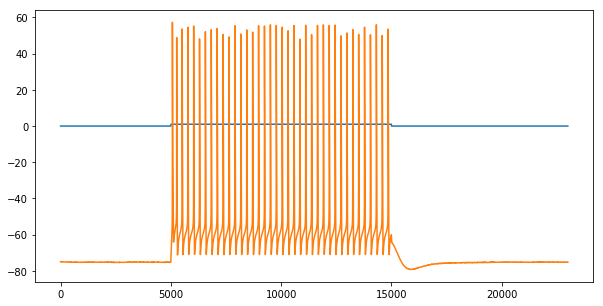

In [10]:
plt.figure(figsize=(10,5))
plt.plot(I);
plt.plot(u);

## Generate SNPE input format

In [13]:
x = {'data': V.reshape(-1),
       'time': t,
       'dt': dt,
       'I': I}

# Calculate  Summary Statistics

### resting potential and std

In [29]:
rest_pot = np.mean(x['data'][t<t_on])
rest_pot_std = np.std(x['data'][int(.9*t_on/dt):int(t_on/dt)])

## Investigate spikes

In [18]:
v = np.array(x['data'])

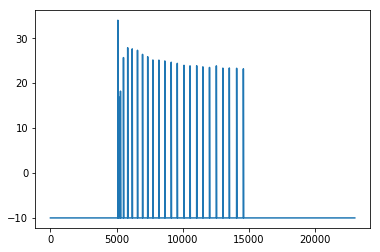

In [19]:
# put everything to -10 that is below -10 or has negative slope
ind = np.where(v < -10)
v[ind] = -10

plt.plot(v);

In [20]:
ind = np.where(np.diff(v) < 0)
v[ind] = -10

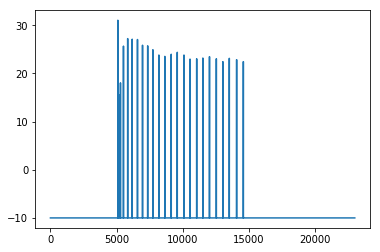

In [21]:
plt.plot(v);

In [23]:
# remaining negative slopes are at spike peaks
ind = np.where(np.diff(v) < 0)
ind

(array([ 5093,  5169,  5293,  5520,  5838,  6181,  6579,  6960,  7350,
         7743,  8196,  8644,  9129,  9586, 10092, 10548, 11052, 11520,
        12020, 12538, 13030, 13518, 14071, 14579]),)

In [24]:
spike_times = np.array(t)[ind]
spike_times

array([ 254.65,  258.45,  264.65,  276.00,  291.90,  309.05,  328.95,
        348.00,  367.50,  387.15,  409.80,  432.20,  456.45,  479.30,
        504.60,  527.40,  552.60,  576.00,  601.00,  626.90,  651.50,
        675.90,  703.55,  728.95])

In [25]:
spike_times_stim = spike_times[(spike_times > t_on) & (spike_times < t_off)]
spike_times_stim

array([ 254.65,  258.45,  264.65,  276.00,  291.90,  309.05,  328.95,
        348.00,  367.50,  387.15,  409.80,  432.20,  456.45,  479.30,
        504.60,  527.40,  552.60,  576.00,  601.00,  626.90,  651.50,
        675.90,  703.55,  728.95])

In [28]:
# number of spikes
if spike_times_stim.shape[0] > 0:
    spike_times_stim = spike_times_stim[np.append(1, np.diff(spike_times_stim))>0.5]

spike_times_stim

array([ 254.65,  258.45,  264.65,  276.00,  291.90,  309.05,  328.95,
        348.00,  367.50,  387.15,  409.80,  432.20,  456.45,  479.30,
        504.60,  527.40,  552.60,  576.00,  601.00,  626.90,  651.50,
        675.90,  703.55,  728.95])

In [55]:
spike_count = np.shape(spike_times_stim)[0]
spike_count

24

## Momements

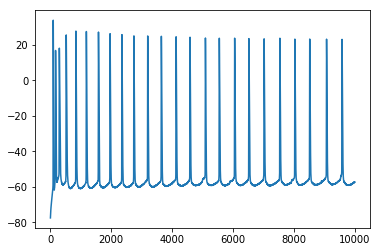

In [52]:
plt.plot(x['data'][(t > t_on) & (t < t_off)]);

In [47]:
n_mom = 6

In [48]:
std_pw = np.power(np.std(x['data'][(t > t_on) & (t < t_off)]), np.linspace(3,n_mom,n_mom-2))
std_pw

array([ 3810.79,  59523.30,  929734.09,  14522136.16])

In [49]:
std_pw = np.concatenate((np.ones(1),std_pw))
std_pw

array([ 1.00,  3810.79,  59523.30,  929734.09,  14522136.16])

In [50]:
moments = spstats.moment(x['data'][(t > t_on) & (t < t_off)], np.linspace(2,n_mom,n_mom-1))/std_pw
moments

array([ 243.97,  3.66,  15.89,  70.74,  323.22])